In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

In [3]:
import os
import datetime
import math

import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

from src.utils.fileutils import get_project_root
from src.data.annotations import load_dataset_annotations
from src.data.annotations import make_continious_labels, dense_to_events, single_track_labels
from src.visualization.events import plot_events, plot_single_track_labels, plot_multitrack_labels
from src.data.annotations import class_color_map


In [4]:
project_root = get_project_root()

In [5]:

annotations = load_dataset_annotations().sort_index(level=(0, 1))
annotations.head(3)

skipping archive
skipping MAESTRO_annotation_notes.md
skipping archive
skipping TUT_annotation_notes.md
skipping File-3.wav
skipping File-2.wav
skipping File-1.wav


start       end annotation annotator
dataset clip   index                                         
bcn     File-1 0      0.478360  0.557077       coug       NaN
               1      0.932499  0.986995       coug       NaN
               2      1.362417  1.980046       peop       NaN

In [6]:
annotations.loc['bcn'].annotation.value_counts().head(20)

peop     2456
rtn      1150
brak      810
door      731
rare      671
horn       93
busd       63
coug       20
blin       20
bkmu       18
musi       16
troll      11
sire        9
whtl        8
Name: annotation, dtype: int64

In [7]:
from src.data.annotations import load_noise_classes

m = load_noise_classes()
m.noise.value_counts()

other           41
speech          19
road_traffic    16
rail_traffic     5
biophony         5
geophony         4
music            4
Name: noise, dtype: int64

In [8]:
# Load from files
soundlevels = pandas.read_parquet(os.path.join(project_root, 'data/processed/soundlevels/LAS.parquet')).droplevel(0).sort_index(level=(0, 1))
soundlevels


level
dataset clip   time                             
bcn     File-1 0 days 00:00:00        -56.752438
               0 days 00:00:00.250000 -57.079689
               0 days 00:00:00.500000 -57.055588
               0 days 00:00:00.750000 -56.784978
               0 days 00:00:01        -56.633011
...                                          ...
tut     b093   0 days 00:03:29.500000 -53.015915
               0 days 00:03:29.750000 -53.112149
               0 days 00:03:30        -53.103120
               0 days 00:03:30.250000 -53.007961
               0 days 00:03:30.500000 -52.817005

[101389 rows x 1 columns]

In [9]:
spectrograms = pandas.read_parquet(os.path.join(project_root, 'data/processed/spectrograms/logmels-64bands-256hop.parquet')).droplevel(0).sort_index(level=(0, 1))
spectrograms.columns = [ float(c) for c in spectrograms.columns ]
spectrograms.loc['bcn']


50.0       97.0       144.0      191.0   \
clip   time                                                                    
File-1 0 days 00:00:00            75.354301  40.264588  76.681526  57.855943   
       0 days 00:00:00.005333333  85.899166  40.264588  77.180887  58.355304   
       0 days 00:00:00.010666666  84.803897  40.264588  79.412479  60.586895   
       0 days 00:00:00.015999999  89.866249  40.264588  86.690475  67.864892   
       0 days 00:00:00.021333332  82.702117  40.264588  79.690053  60.864469   
...                                     ...        ...        ...        ...   
File-3 0 days 02:04:12.991534188  87.833317  43.427678  86.426477  67.600894   
       0 days 02:04:12.996867521  74.799723  43.427678  82.120245  63.294661   
       0 days 02:04:13.002200854  96.926584  43.427678  91.646232  72.820648   
       0 days 02:04:13.007534187  94.582902  43.427678  78.398016  59.572432   
       0 days 02:04:13.012867520  93.655711  43.427678  88.626240  69.800657   

                                     238.0      285.0      333.0      380.0   \
clip   time                                                                    
File-1 0 days 00:00:00            74.900643  63.477136  72.566953  63.974655   
       0 days 00:00:00.005333333  74.064127  62.640620  62.953525  54.361227   
       0 days 00:00:00.010666666  76.064268  64.640761  68.306854  59.714556   
       0 days 00:00:00.015999999  78.324031  66.900524  62.551029  53.958731   
       0 days 00:00:00.021333332  76.402392  64.978885  64.245343  55.653045   
...                                     ...        ...        ...        ...   
File-3 0 days 02:04:12.991534188  92.531957  81.108450  94.627142  86.034844   
       0 days 02:04:12.996867521  77.280003  65.856496  87.006258  78.413960   
       0 days 02:04:13.002200854  85.088287  73.664780  83.352523  74.760225   
       0 days 02:04:13.007534187  82.236768  70.813261  87.768295  79.175997   
       0 days 02:04:13.012867520  77.719569  66.296062  89.422612  80.830314   

                                     427.0      474.0   ...     5168.0  \
clip   time                                             ...              
File-1 0 days 00:00:00            70.122628  63.411246  ...  46.815062   
       0 days 00:00:00.005333333  61.104361  54.392979  ...  40.773293   
       0 days 00:00:00.010666666  71.555665  64.844283  ...  42.285892   
       0 days 00:00:00.015999999  71.888591  65.177209  ...  45.449112   
       0 days 00:00:00.021333332  72.392779  65.681397  ...  43.184711   
...                                     ...        ...  ...        ...   
File-3 0 days 02:04:12.991534188  92.312114  85.600732  ...  50.081347   
       0 days 02:04:12.996867521  93.312181  86.600799  ...  47.024207   
       0 days 02:04:13.002200854  87.220218  80.508836  ...  48.614321   
       0 days 02:04:13.007534187  90.751456  84.040074  ...  50.235158   
       0 days 02:04:13.012867520  91.703365  84.991983  ...  65.625109   

                                     5425.0     5695.0     5978.0     6275.0  \
clip   time                                                                    
File-1 0 days 00:00:00            43.864919  40.264588  40.676000  40.264588   
       0 days 00:00:00.005333333  41.647647  44.904879  40.565675  40.264588   
       0 days 00:00:00.010666666  43.532511  41.312809  40.264588  40.264588   
       0 days 00:00:00.015999999  46.011247  44.281818  40.264588  40.264588   
       0 days 00:00:00.021333332  43.264915  42.896581  40.264588  40.264588   
...                                     ...        ...        ...        ...   
File-3 0 days 02:04:12.991534188  49.158074  53.393084  50.171414  44.798626   
       0 days 02:04:12.996867521  50.041445  50.765505  54.113088  51.863249   
       0 days 02:04:13.002200854  47.964192  51.685694  52.727913  52.351534   
       0 days 02:04:13.007534187  50.095956  49.903331  51.222043  48.827656   
       0 days 02:04:13.012867520

In [10]:

files = annotations.reset_index().set_index(['dataset', 'clip']).index.unique()
files = files.to_frame()
files = files[files.dataset == 'bcn']

all_classes = list(m.index)

from src.features.soundlevel import compute_intermittency_ratio, compute_event_impacts
from src.data.annotations import clip_events

def compute_class_impacts(events, levels, window='5min'):

    out = []
    window = pandas.Timedelta(window)
    
    duration = levels.index.max()
    for start in numpy.arange(0, duration, window):
        end = start + window
        e = events.copy()
        e = clip_events(e, start=start/pandas.Timedelta(seconds=1), end=end/pandas.Timedelta(seconds=1))
        l = levels.loc[start:end]
        
        e['impact'] = compute_event_impacts(events=e, levels=l)
        e['noise_class'] = e.annotation.map(m.noise.to_dict()).fillna('unknown')

        # FIXME: is summing here sane? 
        s = e.groupby('noise_class').impact.sum().to_frame().T       
        s['time'] = start
        s = s.set_index('time')
        
        out.append(s)

    df = pandas.concat(out)
    return df

    

def analysis(row):
    idx = tuple(row)

    l = soundlevels.loc[idx]
    e = annotations.loc[idx]

    s = compute_class_impacts(e, l)
    return s
    
from src.utils.dataframe import flatten_dataframes
flatten_dataframes(files.apply(analysis, axis=1))


noise_class                        music     other  road_traffic    speech
dataset clip   time                                                       
bcn     File-1 0 days 00:00:00  0.000000 -0.197844      1.116073 -0.039250
               0 days 00:05:00  0.000000 -0.003065      0.783708 -0.014623
               0 days 00:10:00  0.000000 -0.158121      0.843658 -0.040640
               0 days 00:15:00  0.000000  0.044514      0.914219 -0.082361
               0 days 00:20:00  0.000000 -0.277955      0.963146 -0.143981
...                                  ...       ...           ...       ...
        File-3 0 days 01:40:00  0.023647 -0.028648      1.022604 -0.402889
               0 days 01:45:00  0.000000 -0.086690      1.573800 -0.576372
               0 days 01:50:00  0.000000  0.056738      0.827991 -0.489527
               0 days 01:55:00  0.000000 -0.018500      0.906807 -0.308103
               0 days 02:00:00  0.000000  0.069625      0.454498 -0.178684

[74 rows x 4 columns]

dataset  clip  
bcn      File-1    None
         File-2    None
         File-3    None
dtype: object

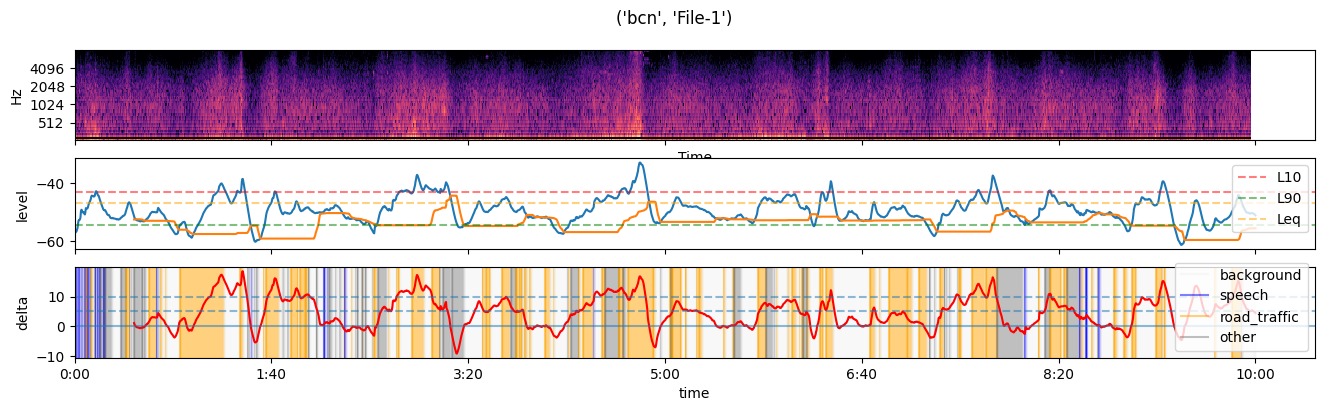

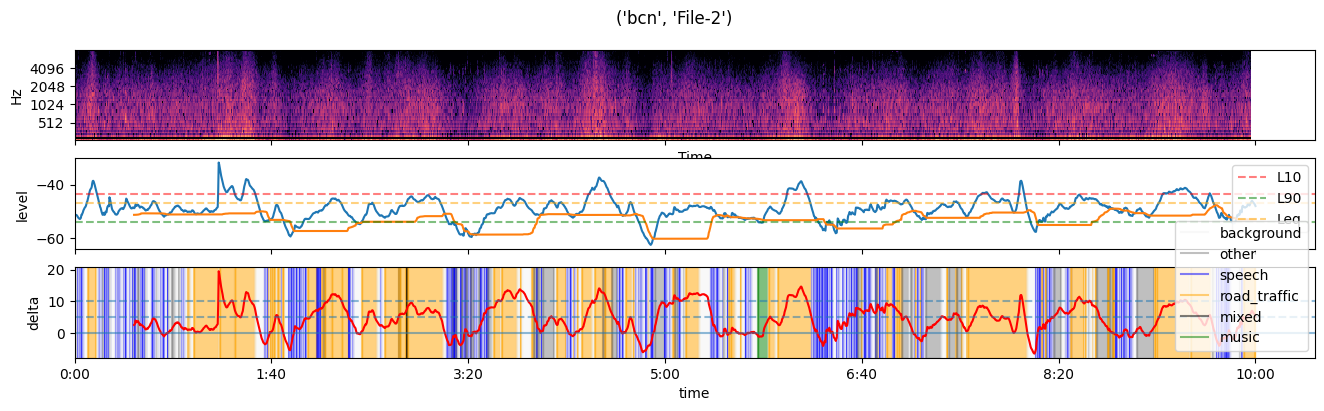

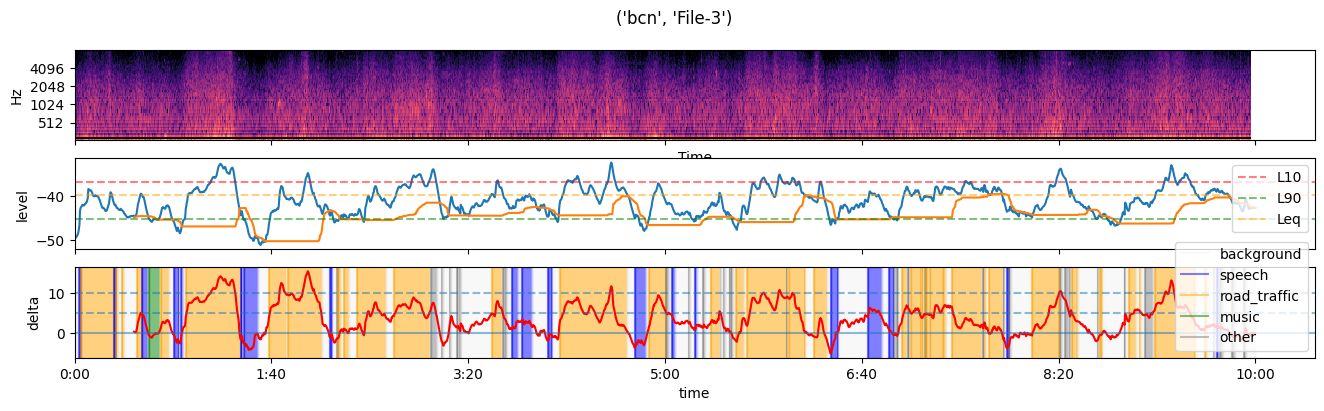

In [17]:

def compute_metric(levels, metric):
    from src.features.soundlevel import compute_ln, compute_leq

    if metric == 'Leq':
        level = float(compute_leq(levels.values))
    elif metric.startswith('L'):
        ln = float(metric[1:])
        level = compute_ln(levels, n=ln)   
    else:
        raise ValueError("Unsupported ")

    return level

def plot_clip(levels, spec, ann, title='',
              soundlevel_summary=['L10', 'L90', 'Leq'],
              soundlevel_summary_colors={'L10': 'red', 'Leq': 'orange', 'L90': 'green'},
             ):

    from src.visualization.events import plot_events, plot_single_track_labels, plot_multitrack_labels
    from src.features.spectrogram import plot_spectrogram
    from src.data.annotations import class_color_map

    aspect = 4.0
    height = 4.0
    width = aspect * height
    fig, (spec_ax, level_ax, label_ax) = plt.subplots(3, figsize=(width, height), sharex=True)

    # spectrogram
    plot_spectrogram(spec_ax, spec)
    
    # soundlevels
    from src.features.soundlevel import compute_background
    ll = compute_background(levels.level, window=30.0)
    ll = ll.reset_index()
    ll['time'] = ll['time'] / pandas.Timedelta(seconds=1)
    seaborn.lineplot(ax=level_ax, data=ll, y='level', x='time')
    seaborn.lineplot(ax=level_ax, data=ll, y='background', x='time')

    for metric in soundlevel_summary:
        metric_level = compute_metric(levels, metric)
        color = soundlevel_summary_colors.get(metric, 'gray')
        level_ax.axhline(metric_level, ls='--', alpha=0.5, color=color, label=metric)

    level_ax.legend()
    

    # annotations
    classes=all_classes
    time_resolution=0.100

    ann['noise_class'] = ann.annotation.map(m.noise.to_dict()).fillna('unknown')
    last = ann['end'].max()
    multi = make_continious_labels(ann, length=math.ceil(last/time_resolution),
                                 time_resolution=time_resolution,
                                 class_column='noise_class',
                                 classes=classes)

    single = single_track_labels(multi)
    seaborn.lineplot(ax=label_ax, data=ll, y='delta', x='time', color='red')
    label_ax.axhline(0.0, ls='-', alpha=0.5)
    label_ax.axhline(5.0, ls='--', alpha=0.5)
    label_ax.axhline(10.0, ls='--', alpha=0.5)
    plot_single_track_labels(label_ax, single, colors=class_color_map, alpha=0.5)

    if title:
        fig.suptitle(title)


files = annotations.reset_index().set_index(['dataset', 'clip']).index.unique()
files = files.to_frame()
files = files[files.dataset == 'bcn']

all_classes = list(m.index)

from src.features.soundlevel import compute_intermittency_ratio, compute_event_impacts

def plot(row):
    # select a subset of data
    start = pandas.Timedelta(minutes=0)
    end = pandas.Timedelta(minutes=10.0)
    idx = tuple(row)
    l = soundlevels.loc[idx].loc[start:end]
    s = spectrograms.loc[idx].loc[start:end]
    e = annotations.loc[idx].copy()
    e = clip_events(e, start=start/pandas.Timedelta(seconds=1), end=end/pandas.Timedelta(seconds=1))
    e['noise_class'] = e.annotation.map(m.noise.to_dict()).fillna('unknown')

    plot_clip(l, s, e, title=f'{str(idx)}')

files.apply(plot, axis=1)
